# CRM Analytics

A ideia de uma analise de CRM representa as vendas de uma compania e a performance servico prestado ao consumidor. Nao so isso, mas a analise dos dados de um CRM podem ajudar o negocio a tomar decisoes estrategicas baseada em dados.

In [1]:
import os
import datetime
import warnings
import pandas as pd 
import numpy as np
import datetime as dt
from operator import attrgetter
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import plotly.graph_objs as go
from plotly.offline import iplot
import squarify

In [2]:
df = pd.read_csv('../assets/data.csv',
    header = 0,
    encoding = 'unicode_escape',
    dtype = {'CustomerID': str, 'InvoiceID': str},
    parse_dates = ['InvoiceDate'], 
    infer_datetime_format = True)
df.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850,United Kingdom


## Data Understanding
    
Typically e-commerce datasets are proprietary and consequently hard to find among publicly available data. However, The UCI Machine Learning Repository has made this dataset containing actual transactions from 2010 and 2011. The dataset is maintained on their site, where it can be found by the title "Online Retail".

### Variable Description
    
- **InvoiceNo:** Invoice number that consists 6 digits. If this code starts with letter 'c', it indicates a cancellation.
- **StockCode:** Product code that consists 5 digits.
- **Description:** Product name.
- **Quantity:** The quantities of each product per transaction.
- **InvoiceDate:** Represents the day and time when each transaction was generated.
- **UnitPrice:** Product price per unit.
- **CustomerID:** Customer number that consists 5 digits. Each customer has a unique customer ID.
- **Country:** Name of the country where each customer resides.

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 541909 entries, 0 to 541908
Data columns (total 8 columns):
 #   Column       Non-Null Count   Dtype         
---  ------       --------------   -----         
 0   InvoiceNo    541909 non-null  object        
 1   StockCode    541909 non-null  object        
 2   Description  540455 non-null  object        
 3   Quantity     541909 non-null  int64         
 4   InvoiceDate  541909 non-null  datetime64[ns]
 5   UnitPrice    541909 non-null  float64       
 6   CustomerID   406829 non-null  object        
 7   Country      541909 non-null  object        
dtypes: datetime64[ns](1), float64(1), int64(1), object(5)
memory usage: 33.1+ MB


- Existem Missing Values nos campos Customer Id e Description

In [4]:
world_map = df[['CustomerID', 'InvoiceNo', 'Country']
              ].groupby(['CustomerID', 'InvoiceNo', 'Country']
                       ).count().reset_index(drop = False)
countries = world_map['Country'].value_counts()
data = dict(type='choropleth',
            locations = countries.index,
            locationmode = 'country names',
            z = countries,
            text = countries.index,
            colorbar = {'title':'Orders'},
            colorscale='Viridis',
            reversescale = False)

layout = dict(title={'text': "Pedidos por Pais",
                     'y':0.9,
                     'x':0.5,
                     'xanchor': 'center',
                     'yanchor': 'top'},
              geo = dict(resolution = 50,
                         showocean = True,
                         oceancolor = "LightBlue",
                         showland = True,
                         landcolor = "whitesmoke",
                         showframe = True),
             template = 'plotly_white',
             height = 600,
             width = 1000)

choromap = go.Figure(data = [data], layout = layout)
iplot(choromap, validate = False)

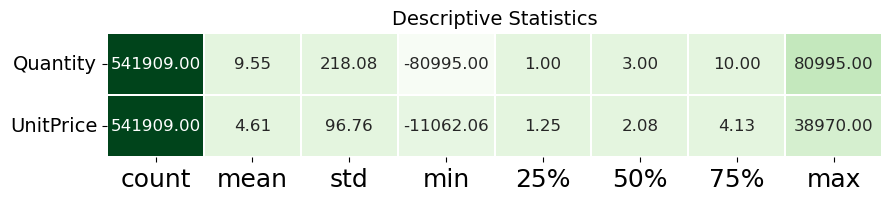

In [5]:
def desc_stats(dataframe):
    desc_df = pd.DataFrame(index= dataframe.columns, 
                           columns= dataframe.describe().T.columns,
                           data= dataframe.describe().T)
    
    f,ax = plt.subplots(figsize=(10,
                                 desc_df.shape[0] * 0.81))
    sns.heatmap(desc_df,
                annot = True,
                cmap = "Greens",
                fmt = '.2f',
                ax = ax,
                linecolor = 'white',
                linewidths = 1.1,
                cbar = False,
                annot_kws = {"size": 12})
    plt.xticks(size = 18)
    plt.yticks(size = 14,
               rotation = 0)
    plt.title("Descriptive Statistics", size = 14)
    plt.show()
    
desc_stats(df.select_dtypes(include = [float, int]))

- Claramente existem alguns outliers que precisam ser removidos nos valores de UnitPrice e Quantidade
- Existem valores Negativos de Unit Price e Quantity (provavelmente devido aos **pedidos cancelados**)

## Data Processing & Cleaning

In [6]:
def replace_with_thresholds(dataframe, variable, q1 = 0.25, q3 = 0.75):
    # IQR (InterQuartile Range) e o metodo que filtra outliers dos dados definindo o range de dados de acordo com os quartils 
    df_ = dataframe.copy()
    quartile1 = df_[variable].quantile(q1)
    quartile3 = df_[variable].quantile(q3)
    iqr = quartile3 - quartile1
    
    up_limit = quartile3 + 1.5 * iqr
    low_limit = quartile1 - 1.5 * iqr
    df_.loc[(df_[variable] < low_limit), variable] = low_limit
    df_.loc[(df_[variable] > up_limit), variable] = up_limit
    
    return df_

def ecommerce_preprocess(dataframe):
    df_ = dataframe.copy()
    
    #Missing Values
    df_ = df_.dropna()
    
    #Ordens Canceladas (Quantities e UnitPrice Negativas)
    df_ = df_[~df_['InvoiceNo'].str.contains('C', na = False)]
    df_ = df_[df_['Quantity'] > 0]
    
    #Replacing Outliers
    df_ = replace_with_thresholds(df_, "Quantity", q1 = 0.01, q3 = 0.99)
    df_ = replace_with_thresholds(df_, "UnitPrice", q1 = 0.01, q3 = 0.99)
    
    #Total Price
    df_["TotalPrice"] = df_["Quantity"] * df_["UnitPrice"]
    
    return df_

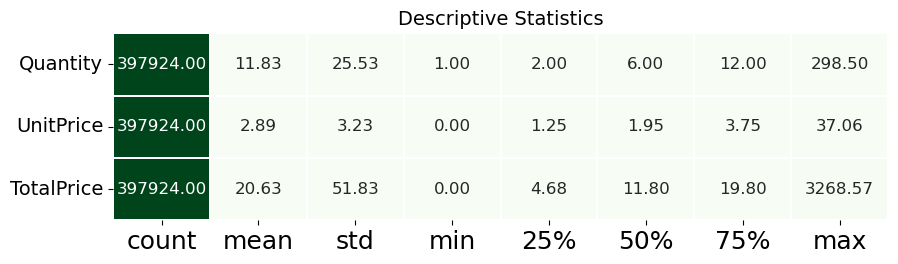

In [7]:
df = ecommerce_preprocess(df)

desc_stats(df.select_dtypes(include = [float, int]))

In [8]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 397924 entries, 0 to 541908
Data columns (total 9 columns):
 #   Column       Non-Null Count   Dtype         
---  ------       --------------   -----         
 0   InvoiceNo    397924 non-null  object        
 1   StockCode    397924 non-null  object        
 2   Description  397924 non-null  object        
 3   Quantity     397924 non-null  float64       
 4   InvoiceDate  397924 non-null  datetime64[ns]
 5   UnitPrice    397924 non-null  float64       
 6   CustomerID   397924 non-null  object        
 7   Country      397924 non-null  object        
 8   TotalPrice   397924 non-null  float64       
dtypes: datetime64[ns](1), float64(3), object(5)
memory usage: 30.4+ MB


### Analise RFM

A análise RFM (Recency, Frequency and Monetary, ou Recência, Frequência e Monetário) é uma forma de segmentação da sua base de clientes com base em quão engajados com o seu negócio eles estão. O objetivo deste tipo de análise é agrupar ou clusterizar os clientes do seu negócio, de modo a entender quem são aqueles clientes que mais consomem o seu produto e serviço e aqueles que menos consomem.

- Recency (ou recência): quanto mais recente tiver sido a última compra de um cliente, mais pontos ele recebe aqui.
- Frequency (ou frequência): quanto maior for o número de compras de um cliente, maior também será sua pontuação neste quesito.
- Monetary (ou monetário): aqui, estamos falando sobre o parâmetro que gera valor monetário para o negócio, o qual precisa ser definido previamente para que seja possível definir a recência e a frequência.




In [9]:
print(df['InvoiceDate'].max())

2011-12-09 12:50:00


In [10]:
today_date = dt.datetime(2011,12,11) # Proximo dia Util a ultima data de invoice

rfm = df.groupby('CustomerID').agg({'InvoiceDate': lambda x: (today_date - x.max()).days,
                                    'InvoiceNo': lambda x: x.nunique(),
                                    'TotalPrice': lambda x: x.sum()})

rfm.columns = ['recency', 'frequency', 'monetary']
rfm = rfm.reset_index()

rfm.head()

,CustomerID,recency,frequency,monetary
0,12346,326,1,310.44
1,12347,3,7,4310.00
2,12348,76,4,1770.78
3,12349,19,1,1491.72
4,12350,311,1,331.46


In [11]:
# SCORES RFM
def get_rfm_scores(dataframe) -> pd.core.frame.DataFrame:

    df_ = dataframe.copy()
    df_["recency_score"] = pd.qcut(df_["recency"], 5, labels=[5, 4, 3, 2, 1])
    df_["frequency_score"] = pd.qcut(
        df_["frequency"].rank(method="first"), 5, labels=[1, 2, 3, 4, 5]
    )
    df_["monetary_score"] = pd.qcut(df_["monetary"], 5, labels=[1, 2, 3, 4, 5])
    df_["RFM_SCORE"] = df_["recency_score"].astype(str) + df_["frequency_score"].astype(
        str
    )

    return df_


rfm = get_rfm_scores(rfm)

In [12]:
# MAPA DE SEGMENTACAO
seg_map = {r'[1-2][1-2]': 'hibernating',
           r'[1-2][3-4]': 'at_Risk',
           r'[1-2]5': 'cant_loose',
           r'3[1-2]': 'about_to_sleep',
           r'33': 'need_attention',
           r'[3-4][4-5]': 'loyal_customers',
           r'41': 'promising',
           r'51': 'new_customers',
           r'[4-5][2-3]': 'potential_loyalists',
           r'5[4-5]': 'champions'}

rfm['segment'] = rfm['RFM_SCORE'].replace(seg_map, regex = True)

rfm.head()

,CustomerID,recency,frequency,monetary,recency_score,frequency_score,monetary_score,RFM_SCORE,segment
0,12346,326,1,310.44,1,1,2,11,hibernating
1,12347,3,7,4310.00,5,5,5,55,champions
2,12348,76,4,1770.78,2,4,4,24,at_Risk
3,12349,19,1,1491.72,4,1,4,41,promising
4,12350,311,1,331.46,1,1,2,11,hibernating


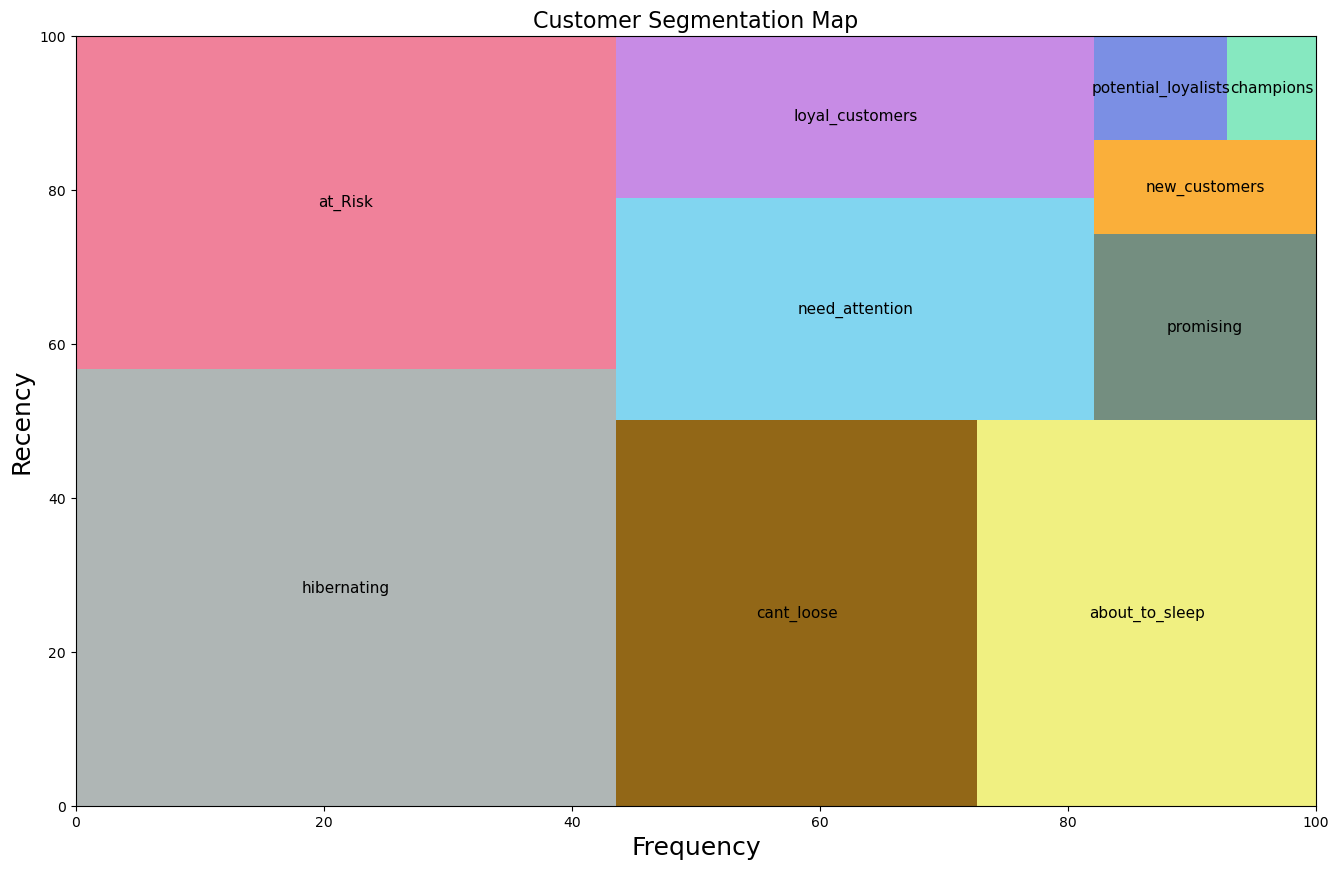

In [17]:
segments = rfm["segment"].value_counts().sort_values(ascending=False)
fig = plt.gcf()
ax = fig.add_subplot()
fig.set_size_inches(16, 10)
squarify.plot(
    sizes=segments,
    label=[label for label in seg_map.values()],
    color=[
        "#AFB6B5",
        "#F0819A",
        "#926717",
        "#F0F081",
        "#81D5F0",
        "#C78BE5",
        "#748E80",
        "#FAAF3A",
        "#7B8FE4",
        "#86E8C0",
    ],
    pad=False,
    bar_kwargs={"alpha": 1},
    text_kwargs={"fontsize": 11},
)
plt.title("Customer Segmentation Map", fontsize=16)
plt.xlabel("Frequency", fontsize=18)
plt.ylabel("Recency", fontsize=18)
plt.show()

### Conclusao

Apesar de conseguirmos chegar ate aqui, essa analise ainda poderia ir muito mais fundo. Mesmo assim, conseguimos gerar diversas informacoes importantes para a Area de Negocio que podera tomar uma decisao com embasamento e atacar os clientes pontualmente.